In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import NonlinearConstraint
from scipy.optimize import minimize

In [2]:
inflow_rule = lambda t: 0.4
A = 0.2
Cv = 0.5
t = np.linspace(0,8,100)
dt = t[1] - t[0]

inflow = lambda x: x[200:300] - inflow_rule(t)
tank1 = lambda x: A*x[:100] - (x[200:300] - x[300:400])
tank1_be = lambda x: x[1:100] - (x[101:200] - x[100:199])/dt
release1 = lambda x: x[300:400] - Cv*np.sqrt(x[100:200])
tank2 = lambda x: A*x[400:500] - (x[300:400] - x[500:600])
tank2_be = lambda x: x[401:500] - (x[601:700] - x[600:699])/dt
release2 = lambda x: x[500:600] - Cv*np.sqrt(x[600:700])

cons = [NonlinearConstraint(inflow, 0.0, 0.0),
        NonlinearConstraint(tank1, 0.0, 0.0),
        NonlinearConstraint(tank1_be, 0.0, 0.0),
        NonlinearConstraint(release1, 0.0, 0.0),
        NonlinearConstraint(tank2, 0.0, 0.0),
        NonlinearConstraint(tank2_be, 0.0, 0.0),
        NonlinearConstraint(release2, 0.0, 0.0),
       ]

fun = lambda x: 0.0
bounds = [(None, None) for i in range(700)]
for i in range(100,200):
    bounds[i] = (0.0, None)
for i in range(600,700):
    bounds[i] = (0.0, None)

bounds[100] = (1e-10, 1e-10)
bounds[600] = (1e-10, 1e-10)
res = minimize(fun, np.ones(700), bounds=bounds, method='trust-constr', constraints=cons)

/home/euan/.local/lib/python3.8/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


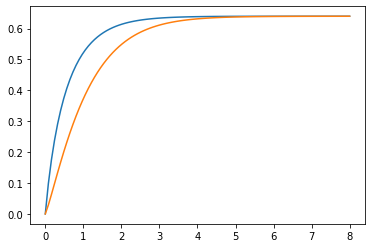

In [3]:
plt.plot(t, res.x[100:200])
plt.plot(t, res.x[600:700])

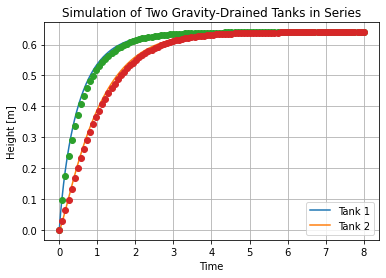

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint

# 2. Fix parameter values
A = 0.2
Cv = 0.5
qin = 0.4

# 3. Write a function to evaluate RHS of the differential equations
def deriv(X,t,qin=0):
    h1,h2 = X
    dh1 = (qin - Cv*np.sqrt(h1))/A
    dh2 =  (Cv*np.sqrt(h1) - Cv*np.sqrt(h2))/A 
    return [dh1,dh2]

# 4. Choose initial conditions and time grid
IC = [0,0]
time = np.linspace(0,8,500)

# 5. Perform the simulation by numerical solution of the differential equations
sol = odeint(deriv,IC,time,args=(qin,))

# 6. Prepare visualizations and post-processing
plt.plot(time,sol)
plt.legend(['Tank 1','Tank 2'])
plt.xlabel('Time')
plt.ylabel('Height [m]')
plt.title('Simulation of Two Gravity-Drained Tanks in Series')
plt.grid()

plt.plot(t, res.x[100:200],'o')
plt.plot(t, res.x[600:700],'o')

# Cascade Reservoirs APM

In [5]:
from scipy import interpolate

time = np.linspace(0,1,10)
dt = time[1] - time[0]

#Usage Requirements (km3/yr)
Vuse1 = 0.03
Vuse2 = 0.05
Vuse3 = 0.02
Vuse4 = 0.00

#Area of Reservoir / Lake (km2)
A1 = 13.4
A2 = 12.0
A3 = 384.5
A4 = 4400

#Initial Volume of Reservoir / Lake (km3)
V1 = 0.26
V2 = 0.18
V3 = 0.68
V4 = 22.0

#Evaporation Rates (km3/yr)
Vevap1 = 1e-5 * A1
Vevap2 = 1e-5 * A2
Vevap3 = 1e-5 * A3
Vevap4 = 0.5e-5 * A4 #, for salt water (Great Salt Lake)


#Inflow Rates (km3/yr)
time_vin = np.linspace(0,1,13)
vin = [0.13,0.13,0.13,0.21,0.21,0.21,0.13, 0.13,0.13,0.13,0.13,0.13,0.13]
Vflow_in1 = interpolate.interp1d(time_vin, vin, kind='previous')

class Flowsheet:
    def __init__(self, time):
        self.time = time
        self.len_var = len(time)
        self.curr_var_idx = 0
        
    def process_stream(self, *args, **kwargs):
        stream = ProcessStream(*args, **kwargs)
        idx0 = self.curr_var_idx
        idx1 = idx0 + len(time)
        idx2 = idx0 + 2*len(time)
        stream.Q_idx=list(range(idx0,idx1))
        stream.h_idx=list(range(idx1,idx2))
        
        self.curr_var_idx = idx2
        
        return stream
        
class ProcessStream:
    def __init__(self, cv=0.03, Q_idx=[], h_idx=[]):
        self.Cv = cv
        self.Q_idx = Q_idx
        self.h_idx = h_idx
         
    def update_inputs(self, x):
        self.Q = x[self.Q_idx]
        self.h = x[self.h_idx]
        
    def equation(self, x):
        self.update_inputs(x)
    
        return self.Q - self.Cv*np.sqrt(self.h)
    
def Reservoir:
    def __init__(self, area=0.03, initial_volume=0.0, h_idx=[], V_idx=[], dV_idx=[]):
        self.area = area
        self.dV_idx = dV_idx
        self.V_idx = V_idx
        self.h_idx = h_idx
        self.Q = None
         
    def update_inputs(self, x):
        self.dV = x[self.dV_idx]
        self.V = x[self.V_idx]
        self.h = x[self.h_idx]
        
    def mass_balance(self, x):
        self.update_inputs(x)
    
        return self.dV - (sum(self.inlets) - sum(self.outlets))
    
    def height(self, x):
        self.update_inputs(x)
    
        return self.h - self.V/self.A*1000
    
# process streams (km3/yr) with height in meters
f = Flowsheet(time)
outflow1 = Valve(cv=0.03) 
outflow2 = Valve(cv=0.015) 
outflow3 = Valve(cv=0.060) 
outflow4 = Valve(cv=0.000)

jordanelle = Reservoir(area=A1, initial_volume=V1)
f.connect(Vuse1, jordanelle.inlet)
f.connect(Vevap1, jordanelle.inlet)
f.connect(jordanelle.outlet, )
f.connect(Vevap1, jordanelle.inlet)

#heights in meters
def jord_h(x):
    h1 = x[10:20]
    V1 = x[70:80]
    return h1 - V1/A1*1000

def creek_h(x):
    h2 = x[30:40]
    V2 = x[90:100]
    return h2 - V2/A2*1000

def utah_h(x):
    h3 = x[50:60]
    V3 = x[110:120]
    return h3 - V3/A3*1000

# Mass Balances
def jord(x):
    Vflow_out1 = x[0:10]
    V1 = x[70:80]
    dV1 = x[80:90]
    return dV1 - (Vflow_in1(time) - Vuse1 - Vevap1 - Vflow_out1)

def creek(x):
    Vflow_out1 = x[0:10]
    Vflow_out2 = x[20:30]
    V2 = x[90:100]
    dV2 = x[100:110]
    return dV2 - (Vflow_out1 - Vuse2 - Vevap2 - Vflow_out2)

def utah(x):
    Vflow_out2 = x[20:30]
    Vflow_out3 = x[40:50]
    V3 = x[110:120]
    dV3 = x[120:130]
    return dV3 - (Vflow_out2  - Vuse3 - Vevap3 - Vflow_out3)

def lake(x):
    Vflow_out3 = x[40:50]
    Vflow_out4 = x[60:70]
    V4 = x[130:140]
    dV4 = x[140:150]
    return dV4 - (Vflow_out3  - Vuse4 - Vevap4 - Vflow_out4)

# Finite difference scheme
def jord_fd(x):
    V1 = x[70:80]
    dV1 = x[80:90]
    return dV1[1:] - (V1[1:]-V1[:-1])/dt

def creek_fd(x):
    V2 = x[90:100]
    dV2 = x[100:110]
    return dV2[1:] - (V2[1:]-V2[:-1])/dt

def utah_fd(x):
    V3 = x[110:120]
    dV3 = x[120:130]
    return dV3[1:] - (V3[1:]-V3[:-1])/dt

def lake_fd(x):
    V4 = x[130:140]
    dV4 = x[140:150]
    return dV4[1:] - (V4[1:]-V4[:-1])/dt


cons = [NonlinearConstraint(outflow1.equation, 0.0, 0.0),
        NonlinearConstraint(outflow2, 0.0, 0.0),
        NonlinearConstraint(outflow3, 0.0, 0.0),
        NonlinearConstraint(outflow4, 0.0, 0.0),
        NonlinearConstraint(jord_h, 0.0, 0.0),
        NonlinearConstraint(creek_h, 0.0, 0.0),
        NonlinearConstraint(utah_h, 0.0, 0.0),
        NonlinearConstraint(jord, 0.0, 0.0),
        NonlinearConstraint(creek, 0.0, 0.0),
        NonlinearConstraint(utah, 0.0, 0.0),
        NonlinearConstraint(lake, 0.0, 0.0),
        NonlinearConstraint(jord_fd, 0.0, 0.0),
        NonlinearConstraint(creek_fd, 0.0, 0.0),
        NonlinearConstraint(utah_fd, 0.0, 0.0),
        NonlinearConstraint(lake_fd, 0.0, 0.0),
       ]

# 150 variables
# 150 eq - 4 = 146 equations
# fix the 4 initial conditions

fun = lambda x: 0.0
bounds = [(None, None) for i in range(150)]

# bound heights
for i in range(10,20):
    bounds[i] = (0.0, None)
for i in range(30,40):
    bounds[i] = (0.0, None)
for i in range(50,60):
    bounds[i] = (0.0, None)

# fix initial conditions
bounds[70] = (V1, V1)
bounds[90] = (V2, V2)
bounds[110] = (V3, V3)
bounds[130] = (V4, V4)

res = minimize(fun, np.ones(150)*100, bounds=bounds, method='trust-constr', constraints=cons)


/home/euan/.local/lib/python3.8/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


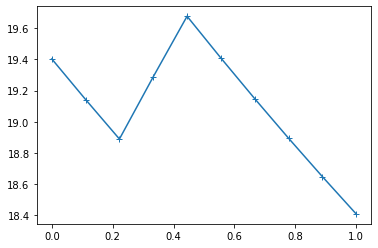

In [6]:
plt.plot(time, res.x[10:20], '+-')
#plt.plot(t, res.x[300:400])

In [7]:
time_vin

array([0.        , 0.08333333, 0.16666667, 0.25      , 0.33333333,
       0.41666667, 0.5       , 0.58333333, 0.66666667, 0.75      ,
       0.83333333, 0.91666667, 1.        ])